In [1023]:
import numpy as np
from torch.autograd import Variable
import torch
import random
from typing import List, Callable, Iterable
import matplotlib.pyplot as plt
import time
import numdifftools as nd

seed = 999
torch.manual_seed(seed)
random.seed(seed)

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'


## Linearization Method

In [1024]:
import scipy.optimize as opt
from scipy.optimize import LinearConstraint, NonlinearConstraint, Bounds

In [1025]:
def Gradient(func: Callable, X):
    return nd.Gradient(func)(X)
def Derivative(func: Callable, X, order):
    return nd.Derivative(func, n=order)(X)
def ReLu(x):
    return 0 if x < 0 else x
def Loss(obj, constraints, X, penalty=1):
    return obj(X) + penalty * sum([ReLu(con(X)) for con in constraints])

In [1026]:
'''
δ, subscript of I(X), should be non-negative
inf implies I_δ(X) == I(X)
'''
DELTA = np.inf 
N = 1
EPSILON = 0.5

LOSS_PENALITY = 10000

In [1027]:
def Initialize():
    # obj = lambda X: (X[1]**2)-3
    # cons =[
    #     lambda X: 0.0, # the assumption on the top of page 44
    #     lambda X: 10**X[0] - 1e-1,
    #     lambda X: 10**X[1] - 1e-3,
    #     lambda X: -(X**2).sum() + 20,
    # ]
    
    obj = lambda X: Ｘ[0]**2 + X[1]**2 + 10
    cons =[
        lambda X: 0.0, # the assumption on the top of page 44
        lambda X: (X**6).sum() - 20,
        lambda X: (X[1]**8) - 20,
        lambda X: X.sum() - 10,
        lambda X: 3*X[0] - 2*X[1] + 1,
        lambda X: (X**2).sum() - 10,
    ]

    # initial guess
    X = np.array([30.0, -8.0])

    # real answer
    res = opt.minimize(obj, X, constraints=[NonlinearConstraint(i, -np.inf, 0) for i in cons])
    print(res)
    assert(res.success)
    return obj, cons, X

obj, cons, X= Initialize()

     fun: 10.076923076923077
     jac: array([-0.46153843,  0.30769229])
 message: 'Optimization terminated successfully'
    nfev: 16
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([-0.23076923,  0.15384615])


In [1028]:

# Our ans
our_losses = []
num_iterate = 30

def FindP(X, constraints):
    '''Find I_δ(X)'''
    assert(len(constraints) > 0)
    F = lambda X: max([f(X) for f in constraints])
    I_delta = []
    for i, f_i in enumerate(constraints):
        if f_i(X) >= F(X) - DELTA:
            I_delta.append(i)
    '''approximate objective'''
    quad_obj = lambda p: np.dot(Gradient(obj, X), p) + 0.5*np.dot(p, p)

    '''approximate constraints'''
    grad_of_cons = []
    val_of_cons = []
    for i in I_delta:
        val_of_cons.append(constraints[i](X))
        grad_of_cons.append(Gradient(constraints[i], X))

    # linear_cons = [np.dot(grad, p) + val for grad, val in zip(grad_of_cons, val_of_cons)]

    res = opt.minimize(quad_obj, X, constraints=[LinearConstraint(grad, -np.inf, -val) for grad, val in zip(grad_of_cons, val_of_cons)])
    if not res.success:
        print(res)
        raise(BaseException)
    p = (res.x) # solution of the quadratic programming problem
    return p, F

def HonestOptimize(X, all_constraints):
    # print("---> HonestOptimize <---")
    p, F = FindP(X, all_constraints)
    '''gradient filter'''
    '''g_i(w) = f_i(x + w * p), w is scalar '''
    faulty_constraints = []
    honest_constraints = []
    gd_filter_threshold = 10
    for i in range(len(all_constraints)):
        g_i = lambda w: all_constraints[i](X + w*p)
        if Derivative(g_i, 0, order=2) > gd_filter_threshold:
            faulty_constraints.append(all_constraints[i])
            # print(f'fault: {i}')
        else:
            honest_constraints.append(all_constraints[i])
        # print(f'{Derivative(g_i, 0, order=2)}_{X}')
    assert(len(honest_constraints) > 0)
    p, F = FindP(X, honest_constraints)
    alpha = 1
    # if (len(honest_constraints) == len(all_constraints)):
    #     while obj(X + alpha*p) + N*F(X + alpha*p) > obj(X) + N*F(X) - alpha*EPSILON*np.dot(p, p):
    #         alpha /= 2

    X += alpha*p
    # print(f'obj: {obj(X)}, X: ({X[0]:4f}, {X[1]:4f}), alpha: {alpha}, |p|: {sum(p**2):4f}', end='\n')
    # print("---> Done <---")
    return X, faulty_constraints

def BizantineOptimization(X, faulty_constraints):
    # print("---> BizantineOptimization <---")
    k = 50  # constant > 0
    t = 50  # constant > 0

    if len(faulty_constraints) == 0:
        # print("---> No Fault Done <---")
        return X
    new_obj = lambda U: obj(U) + k * sum([ReLu(con(U)) for con in faulty_constraints])\
                        + 1/(2*t) * np.square(U-X).sum()
    res = opt.minimize(new_obj, X, method='Nelder-Mead')
    if not res.success:
        # print(res)
        raise(BaseException)
    print(res)
    # print("---> Done <---")
    return res.x
    



 final_simplex: (array([[-0.29704735,  0.07921097],
       [-0.29699351,  0.07920471],
       [-0.29698454,  0.07924519]]), array([19.54455446, 19.54455446, 19.54455446]))
           fun: 19.544554455769443
       message: 'Optimization terminated successfully.'
          nfev: 101
           nit: 52
        status: 0
       success: True
             x: array([-0.29704735,  0.07921097])
iter: 0 | obj:10.094512 | X: [-0.29704735  0.07921097] | loss: 10.094512
iter: 1 | obj:10.086697 | X: [-0.17592896  0.23610656] | loss: 10.086697
iter: 2 | obj:10.086697 | X: [-0.28560951  0.07158574] | loss: 10.086697
iter: 3 | obj:10.086697 | X: [-0.17592896  0.23610656] | loss: 10.086697
iter: 4 | obj:10.086697 | X: [-0.28560951  0.07158574] | loss: 10.086697
iter: 5 | obj:10.086697 | X: [-0.17592896  0.23610656] | loss: 10.086697
iter: 6 | obj:10.086697 | X: [-0.28560951  0.07158573] | loss: 10.086697
iter: 7 | obj:10.086697 | X: [-0.17592896  0.23610657] | loss: 10.086697
iter: 8 | obj:10.086697 |

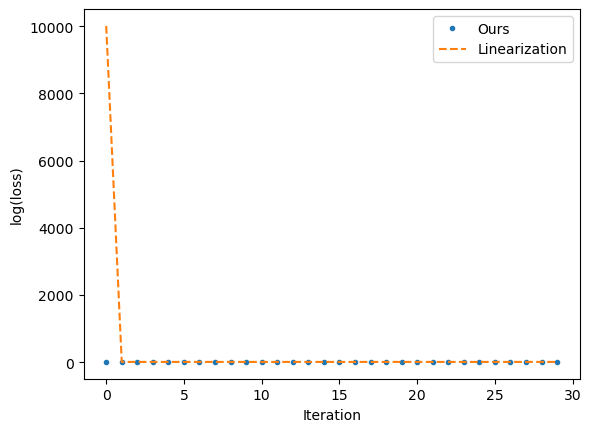

In [1029]:
# Optimization 
for _ in range(num_iterate):
    # print(X)
    X, faulty_constraints = HonestOptimize(X, cons)
    # print(X)
    X = BizantineOptimization(X, faulty_constraints)
    loss = Loss(obj, cons, X, penalty=LOSS_PENALITY)
    our_losses.append(loss)
    # print(f'iter: {_} | obj:{obj(X):4f} | X: {X} | loss: {loss:4f}')
    
linear_losses = []
obj, cons, X = Initialize()

for _ in range(num_iterate):
    p, F = FindP(X, cons)
    alpha = 1
    while obj(X + alpha*p) + N*F(X + alpha*p) > obj(X) + N*F(X) - alpha*EPSILON*np.dot(p, p):
        alpha /= 2

    X += alpha*p
    loss = Loss(obj, cons, X, penalty=LOSS_PENALITY)
    linear_losses.append(loss)
    # print(f'{_}  obj: {obj(X)}, X: ({X[0]:4f}, {X[1]:4f}), alpha: {alpha}, |p|: {sum(p**2):4f}', end='\n')

plt.plot(range(num_iterate), (our_losses), '.', label='Ours')
plt.plot(range(num_iterate), (linear_losses), '--', label='Linearization')
plt.xlabel('Iteration')
plt.ylabel('log(loss)')
plt.legend()
plt.show()


In [1030]:
Loss(np.array([ 1.89133804 -2.92741078]), obj, cons)

TypeError: 'numpy.ndarray' object is not callable